# ADCP Transect Plotting

This notebook demonstrates a simple plotting exercise for ADCP data across a transect, using the output of a VirtualShip expedition. There are example plots embedded at the end, but these will ultimately be replaced by your own versions as you work through the notebook.

The plot(s) we will produce are simple plots which follow the trajectory of the expedition as a function of distance from the start, and are intended to be a starting point for your analysis. Because the `ADCP` instrument is an underway/onboard instrument, this means we benefit from continuous recordings across the length of the ship's track (unlike overboard instruments such as CTDs which have to deployed at individual sampling sites).

<div class="alert alert-block alert-info"> 
<b>NOTE:</b> This notebook assumes that each point along the expedition track is further from the start than the previous point. The code will still work if not, but the resultant plots might not be very intuitive.
</div>

## Set up

#### Imports

The first step is to import the Python packages required for post-processing the data and plotting. 

In [1]:
import cmocean.cm as cmo
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt


#### Data directory

Next, you should set `data_dir` to be the path to your expedition results in the code block below. You should replace `"/path/to/EXPEDITION/results/"` with the path for your machine.

<div class="alert alert-block alert-success"> 
<b>Tip:</b> You can get the path to your expedition results by navigating to to the folder in Terminal (using `cd`) and then using the `pwd` command. This will print your working directory which you can copy to the `data_dir` variable in this notebook. Don't forget to keep it as a string (in "quotation" marks)!
</div>

In [7]:
data_dir = "/path/to/EXPEDITION/results/"  # set this to be where your expedition output data is located on your (virtual) machine

## Load data

We are now ready to read in the data. You can carry on executing the next cells without making changes to the code...

In [3]:
# load ADCP data
adcp_ds = xr.open_dataset(f"{data_dir}/adcp.zarr")
if adcp_ds["obs"].size <= 1:
    raise ValueError("Number of waypoints must be > 1")

## Data post-processing

Before we can continue, we need to do some post-processing to get it ready for plotting. Below are various helper functions which perform tasks such as calculating the ship's distance from the start of the transect at each point and calculating the various velocity components from the ADCP data.

In [4]:
# utility functions


def haversine(lon1, lat1, lon2, lat2):
    """Great-circle distance (meters) between two points."""
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon, dlat = lon2 - lon1, lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return 6371000 * c


def distance_from_start(ds):
    """Array of meters from first waypoint."""
    lon0, lat0 = ds.isel(obs=0)["lon"].values, ds.isel(obs=0)["lat"].values
    d = np.zeros_like(ds["lon"].values, dtype=float)
    for ob, (lon, lat) in enumerate(zip(ds["lon"], ds["lat"], strict=False)):
        d[ob] = haversine(lon, lat, lon0, lat0)
    return d


def calc_velocities(ds):
    """Calculate absolute, parallel and perpendicular (to the ship trajectory) velocities, as well as (compass) direction of flow."""
    Uabs = np.sqrt(ds["U"] ** 2 + ds["V"] ** 2)
    ds_surface = ds.isel(trajectory=0)
    dlon = np.deg2rad(ds_surface["lon"].differentiate("obs"))
    dlat = np.deg2rad(ds_surface["lat"].differentiate("obs"))
    lat = np.deg2rad(ds_surface["lat"])
    alpha = np.arctan(dlat / (dlon * np.cos(lat))).mean("obs")  # cruise direction angle
    Uparallel = np.cos(alpha) * ds["U"] + np.sin(alpha) * ds["V"]  # cross-shore vel
    Uperp = -np.sin(alpha) * ds["U"] + np.cos(alpha) * ds["V"]  # long-shore vel
    direction_rad = np.arctan2(
        ds["U"], ds["V"]
    )  # direction of flow [degrees from north]
    direction_deg = (np.degrees(direction_rad) + 360) % 360

    return Uabs, Uparallel, Uperp, direction_deg


Now we will execute the various post-processing calculations, plus define some extra useful arrays to be used for the plotting...

In [5]:
# distance from start as 1d array
distance_1d = distance_from_start(adcp_ds.isel(trajectory=0))

# calculate velocity components and direction
Uabs, Uparallel, Uperp, direction = calc_velocities(adcp_ds)

# land / sea bed mask
landmask = xr.where(((adcp_ds["U"] == 0) & (adcp_ds["V"] == 0)), 1, np.nan)

## Plotting

<div class="alert alert-block alert-info"> 
<b>Note:</b> The plots produced next are a starting point for your analysis. You are encouraged to make adjustments, for example axis limits and scaling if the defaults not best suited to your specific data. Use your preferred AI coding assistant for help!
</div>

We are now ready to plot our transect data. We will use distance from the start of the transect/expedition for the x-axis, and water column depth for the y-axis. The ADCP data will then be plotted according to the colour map for diagnostic. The profiles across the transect are likely to be different depths because some parts of the ocean are of course shallower than others.

<div class="alert alert-block alert-success"> 
<b>Tip:</b> Press the "Expand Image" button in the top right of the resultant plot to explore the plot in greater detail in a separate tab. Or the "Save As" button to save a copy of the image.
</div>

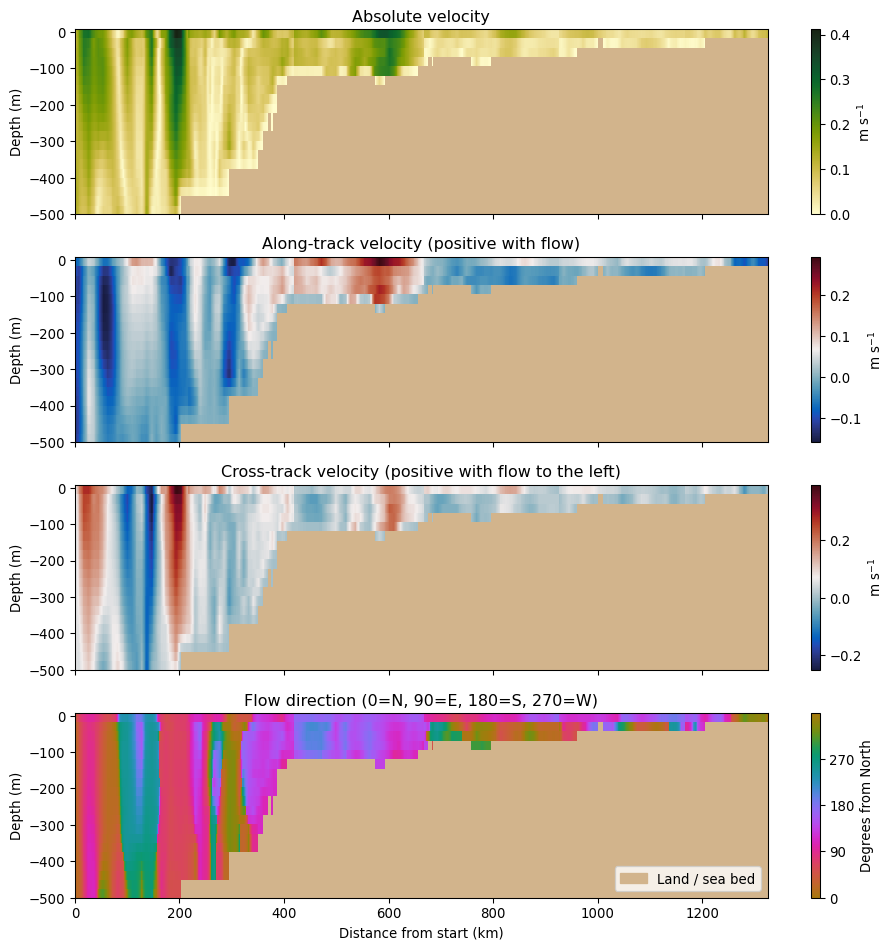

In [ ]:
PLOT_DICT = {
    "Uabs": {
        "data": Uabs,
        "cmap": cmo.speed,
        "label": "Absolute velocity",
    },
    "Uparallel": {
        "data": Uparallel,
        "cmap": cmo.balance,
        "label": "Along-track velocity (positive with flow)",
    },
    "Uperp": {
        "data": Uperp,
        "cmap": cmo.balance,
        "label": "Cross-track velocity (positive with flow to the left)",
    },
    "direction": {
        "data": direction,
        "cmap": cmo.phase,
        "label": "Flow direction (0=N, 90=E, 180=S, 270=W)",
    },
}

# fig
fig, axs = plt.subplots(
    len(PLOT_DICT), 1, figsize=(10, 10), dpi=96, sharex=True, sharey=True
)

norm = mcolors.CenteredNorm()

for idx, ((key, var), ax) in enumerate(zip(PLOT_DICT.items(), axs, strict=False)):
    # adcp data
    mesh = ax.pcolormesh(
        distance_1d / 1000,
        adcp_ds["z"],
        var["data"],
        cmap=var["cmap"],
    )

    # seabed
    ax.pcolormesh(
        distance_1d / 1000,  # distance in km
        adcp_ds["z"],
        landmask,
        cmap=mcolors.ListedColormap([mcolors.to_rgba("tan"), mcolors.to_rgba("white")]),
    )

    # title
    ax.set_title(var["label"])

    # colorbar
    if key == "direction":
        cbar = fig.colorbar(
            mesh,
            ax=ax,
            label="Degrees from North",
            ticks=[0, 90, 180, 270],
        )
    else:
        cbar = fig.colorbar(
            mesh,
            ax=ax,
            label=r"m s$^{-1}$",
        )

    # axis labels
    ax.set_ylabel("Depth (m)")
    if idx == len(axs) - 1:  # bottom panel only for single column of subplots
        ax.set_xlabel("Distance from start (km)")

# legend for sea bed
tan_patch = mpatches.Patch(color=mcolors.to_rgba("tan"), label="Land / sea bed")
axs[-1].legend(handles=[tan_patch], loc="lower right")


plt.tight_layout()

The resultant figure shows various components of the velocity field, derived from ADCP data.

1) Absolute velocity
2) Along-track velocity (where positive values indicate flow in the direction of the ship's track across the the transect)
3) Cross-track velocity (where postive values indicate flow to the left of the ship's direction).
4) The direction of the flow, expressed as degrees from North.

You can use these plots as a starting point to consider how flow dynamics vary over the cross-section. You may find some diagnostics more useful than others, depending on your specific aims!